In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from quantecon.markov import DiscreteDP
from numba import jit

In [2]:
class agent():
    
    '''
    Mapping rule from (a_i, z_i) to s_i:
    
    s_i = a_i * z_size + z_i
    
    To get back a_i, z_i:
    
    a_i = s_i // z_size  (integer division)
    z_i = s_i % z_size
    '''
    
    def __init__(self,
                 r = 0.02,
                 w = 1.0,
                 cbeta = 0.96,
                 a_min = 1e-10,
                 a_max = 18,
                 a_size = 200,
                 P = [[0.9, 0.1],
                     [0.1, 0.9]],
                 z_vals = [0.1, 1.0]):
        
        self.r, self.w, self.cbeta, self.a_min, self.a_max, self.a_size = r, w, cbeta, a_min, a_max, a_size
        
        self.P = np.asarray(P)
        self.z_vals = np.asarray(z_vals)
        self.z_size = len(z_vals)
        
        self.a_vals = np.linspace(a_min, a_max, a_size)
        self.n = self.z_size * self.a_size
        
        # -- setting R and Q -- #
        
        # R
        self.R = np.empty((self.n, self.a_size))
        self.R.fill(-np.inf) # invalid values of utility have to be impossible to choose
        self.set_R()
        
        # Q
        self.Q = np.empty((self.n, self.a_size, self.n))
        self.set_Q()
    
    def set_R(self):
        build_R(self.R, self.z_vals, self.z_size, self.a_size, self.a_vals, self.r, self.w)
    
    def set_Q(self):
        build_Q(self.Q, self.z_vals, self.z_size, self.a_vals, self.a_size, self.P)
        
    def set_prices(self, r, w):
        """
        Use this method to reset prices.  Calling the method will trigger a
        re-build of R.
        """
        self.r, self.w = r, w
        self.set_R()


        
@jit
def build_R(R, z_vals, z_size, a_size, a_vals, r, w):
    n = z_size * a_size
    for i in range(n):
        for j in range(a_size):
            a_i = i // z_size
            z_i = i % z_size

            z = z_vals[z_i]
            a = a_vals[a_i]

            a_1 = a_vals[j]

            c = w * z + (1 + r) * a - a_1
            if c > 0:
                R[i, j] = np.log(c)

@jit
def build_Q(Q, z_vals, z_size, a_val, a_size, P):
    n = a_size * z_size
    for i in range(n):
        z_i = i % z_size
        for z_i_1 in range(z_size):
            for a_i  in range(a_size):
                Q[i, a_i, a_i * z_size + z_i_1] = P[z_i, z_i_1]

 
@jit
def asset_pdf(s_pdf, a_size, z_size):
    '''
    Calculates marginal distri of assets
    pr(asset_i) = sum_j(prob(asset_i & z_j))
    '''
    a_pdf = np.zeros(a_size)
    
    for z_i in range(z_size):
        for a_i in range(a_size):
            a_pdf[a_i] += s_pdf[a_i * z_size + z_i]
        
    return a_pdf

In [3]:
# Example prices
r = 0.03
w = 0.956

# Create an instance of Household
am = agent(a_max=20, r=r, w=w)


# Use the instance to build a discrete dynamic program
am_ddp = DiscreteDP(am.R, am.Q, am.cbeta)

# Solve using policy function iteration
results = am_ddp.solve(method='policy_iteration')

# Simplify names
z_size, a_size = am.z_size, am.a_size
z_vals, a_vals = am.z_vals, am.a_vals
n = a_size * z_size

a_pdf = asset_pdf(results.mc.stationary_distributions[0], a_size, z_size)


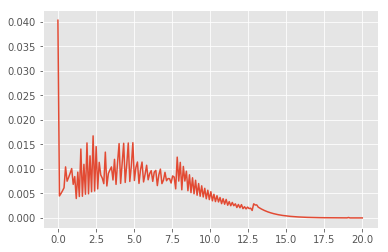

In [4]:
plt.plot(a_vals, a_pdf)

In [5]:
A = 1.0
N = 1.0
calpha = 0.33
cbeta = 0.96
cdelta = 0.05


def r_to_w(r):
    """
    Equilibrium wages associated with a given interest rate r.
    """
    return A * (1 - calpha) * (A * calpha / (r + cdelta))**(calpha / (1 - calpha))

def rd(K):
    """
    Inverse demand curve for capital.  The interest rate associated with a
    given demand for capital K.
    """
    return A * calpha * (N / K)**(1 - calpha) - cdelta

def prices_to_capital_stock(am, r):
    """
    Map prices to the induced level of capital stock.
    
    Parameters:
    ----------
    
    am : Household
        An instance of an aiyagari_household.Household 
    r : float
        The interest rate
    """
    w = r_to_w(r)
    am.set_prices(r, w)
    aiyagari_ddp = DiscreteDP(am.R, am.Q, am.cbeta)
    # Compute the optimal policy
    results = aiyagari_ddp.solve(method='policy_iteration')
    # Compute the stationary distribution
    stationary_probs = results.mc.stationary_distributions[0]
    # Extract the marginal distribution for assets
    asset_probs = asset_pdf(stationary_probs, am.a_size, am.z_size)
    # Return K
    return np.sum(asset_probs * am.a_vals)

In [6]:
'''
Lets actually build an algo now which gets us the equilibrium K and r


'''

@jit
def solve_st_eq(r_min = 0.02, r_max = 0.04, n_vals = 100, tol = 1e-3):
    
    '''
    Solves capital market equilibrium and returns the equilibrium interest rate
    and the equilbrium level of capital
    
    This is the strategy:
    1. We initialize a random value for r
    2. We will get the corresponding firm value of w
    3. We will then solve the household problem for that r and w
    4. The household problem will yield an optimal level of K
    5. feed that K into firm problem to yield firm's optimal value of r := r_star
    6. check |r - r_star| < thresh
    '''
    r_range = np.linspace(r_min, r_max, n_vals)
    #iter = 1
    for r_i in r_range:

        # == Initialize agent == #
        am = agent(a_max=20)

        # == k supply == #
        k_s = prices_to_capital_stock(am, r_i)

        # == corresponding firm r using inverse capital demand func == #
        r_star = rd(k_s)

        # Check deviation
        error = np.absolute(r_i - r_star)

        #print(f'## == Iter {iter}')
        #print('R guess: ', r_i)
        #print('R star: ', r_star)
        #print('Error: ', error)

        #iter += 1
        if error < tol:
            r_eq = r_i
            k_eq = k_s
            return r_eq, k_eq
            break
    
    
(r_eq, k_eq) = solve_st_eq()